In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import gammaincc
from scipy.stats.distributions import chi2
import scipy.optimize as op
import pandas as pd
import corner
from tqdm import tqdm

In [2]:
plt.rcParams.update({'font.size':14})

In [3]:
# read in and plot data

data = pd.read_pickle('data/data.pkl').T

t_ar = data[0]
n_obs = len(t_ar)

err = data[1]

data = data[2:]

## Q1.) Corner Plot of Sample 10
For the prior of the parameters - 

Amplitudes: gaussian centered at 0 with $\sigma$ equals to the maximum deflection to the mean value

Bias: gaussiam centered at the mean with $\sigma$ equals to the mean

Period: 1/T (Jeffreys Prior)

In [4]:
t_tot = t_ar[-1] - t_ar[0]

f_min = .5/t_tot/2*np.pi
f_max = n_obs/t_tot

t_min = 1/f_max
t_max = 1/f_min

In [5]:
def chi2_2_freq(theta, t_ar, data, err, omega2, omega = 2*np.pi/100):
    a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), 
                      np.cos(omega2*t_ar), np.sin(omega2*t_ar), 
                      np.ones(n_obs)])
    return np.sum(((theta.dot(a_mat) - data)/err)**2)


def model_2_freq(theta, t_ar, omega = 2*np.pi/100):
    omega2 = 2*np.pi/theta[-1]
    theta = theta[:-1]
    a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), 
                      np.cos(omega2*t_ar), np.sin(omega2*t_ar), 
                      np.ones(n_obs)])
    return theta.dot(a_mat)



def t_log_prior(t, t_min = t_min, t_max = t_max):
    return -np.log(t)

def amp_log_prior(a, mu, sigma):
    return np.sum(-1/2*((a - mu)/sigma)**2)

def log_posterior(theta, t_ar, data, err, a_mu, a_sigma, omega = 2*np.pi/100):
    a = theta[:-1]
    omega2 = 2*np.pi/theta[-1]
    log_like = -1/2*chi2_2_freq(a, t_ar, data, err, omega2, omega)
    return log_like + t_log_prior(theta[-1]) + amp_log_prior(a, a_mu, a_sigma)
    

In [6]:
p0 = np.array([1.96627683e+00, 2.28645649e+00, 5.39171256e-01, 6.31469334e-01,
               7.00471825e-02, 2.56223398e+02])

In [7]:
mu = np.mean(data[-1])
sigma = np.max(np.abs(data[-1] - mu))

In [8]:
theta_mu = [0,0,0,0,mu]
theta_sigma = [sigma, sigma, sigma, sigma, mu]

mcmc_var = np.array([[ 3.06427921e-04,  7.42080500e-05,  5.08742167e-05,
                      -1.08313104e-04, -9.07335118e-05, -6.36504059e-04],
                     [ 7.42080500e-05,  1.18114784e-04,  7.94797173e-06,
                      -3.02991583e-05, -2.98821638e-05, -4.11677220e-04],
                     [ 5.08742167e-05,  7.94797173e-06,  1.32548150e-04,
                      -3.61652594e-05, -2.80160002e-05,  1.76031102e-05],
                     [-1.08313104e-04, -3.02991583e-05, -3.61652594e-05,
                       1.58225867e-04,  4.91301320e-05,  1.42996005e-04],
                     [-9.07335118e-05, -2.98821638e-05, -2.80160002e-05,
                       4.91301320e-05,  8.36392880e-05,  2.09772417e-04],
                     [-6.36504059e-04, -4.11677220e-04,  1.76031102e-05,
                       1.42996005e-04,  2.09772417e-04,  4.73118127e-03]])

I cheated a little bit here: I used the inverse hessian returned by scipy.optimize to be used as the step-size for MCMC for better and faster convergence.

In [9]:
def mh_MCMC(target, step = 100000, init = p0, var_prop = mcmc_var, **kwargs):
    walk = np.zeros((step + 1, 6))
    walk[0] = init
    threshold = np.log(np.random.rand(step))
    for i in tqdm(range(1, step + 1)):
        next_step = init + np.random.multivariate_normal(mean = np.zeros(6),
                                                         cov = var_prop)
        #print(next_step)
        target_init = target(init, **kwargs)
        r = target(next_step, **kwargs)-target(init, **kwargs)
        #print(np.exp(r))
        if r > threshold[i-1]:
            init = next_step
        walk[i] = init
    return walk

In [10]:
walk = mh_MCMC(log_posterior, t_ar = t_ar, data = data[-1], err = err, a_mu = theta_mu, a_sigma = theta_sigma)

100%|██████████| 100000/100000 [00:24<00:00, 4004.98it/s]


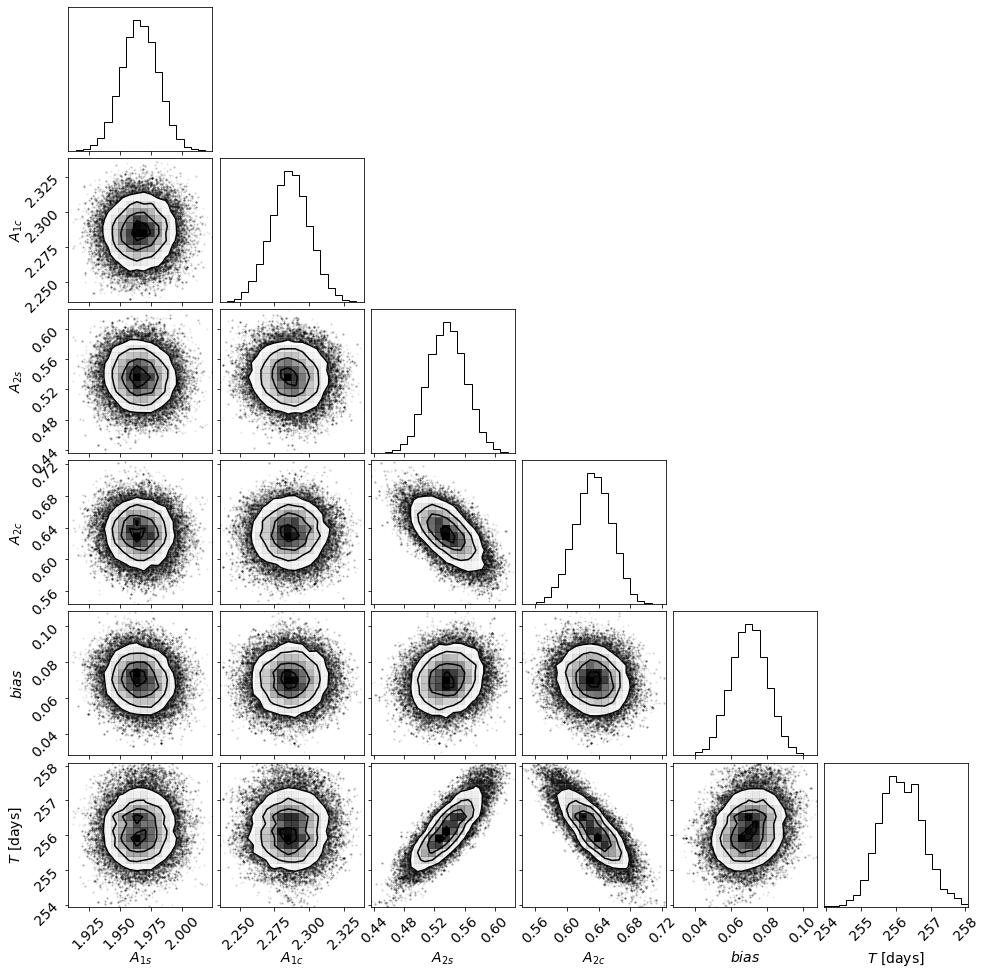

In [12]:
corner.corner(walk[1000:],labels=[
        r"$A_{1s}$",
        r"$A_{1c}$",
        r"$A_{2s}$",
        r"$A_{2c}$",
        r"$bias$",
        r"$T$ [days]"],);

Text(0.5, 1.0, 'Sample 10')

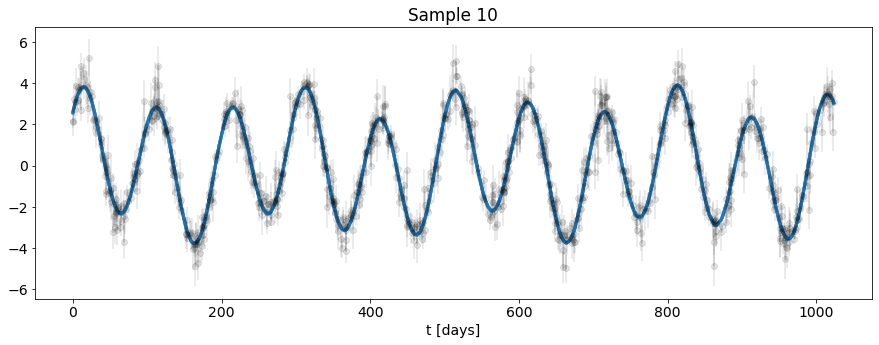

In [13]:
sample = 16
pars = walk[np.random.choice(range(len(walk)), sample, replace = False)]

plt.figure(figsize=(15, 5))
plt.errorbar(t_ar, data[-1], yerr=err,
                color="k", marker="o", alpha=0.1)

for i in range(sample):
    model = model_2_freq(pars[i], t_ar)
    #print(model)
    plt.plot(t_ar, model, alpha = .2, color = 'tab:blue', lw = 3)
plt.xlabel('t [days]')
plt.title('Sample 10')

The spread within the 16 samples are so minimal that it's unresolvable by eye

## Q2.) Visualization of Residual to Find the Second Period

In [14]:
t_2 = np.array([1.35312131e+02,
                1.49392993e+02,
                2.91384710e+02,
                2.56223398e+02])

In [15]:
ind = 10

omega = 2*np.pi/100

a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), np.ones(n_obs)])

cov_inv = (a_mat/err**2).dot(a_mat.T)


cov = np.linalg.inv(cov_inv)

suff_stat = (a_mat/err**2).dot(data[ind].T).T

theta = cov.dot(suff_stat.T).T

period_2 = t_2[3]

Text(0.5, 1.0, 'Sample 10 (period 256.223398 days)')

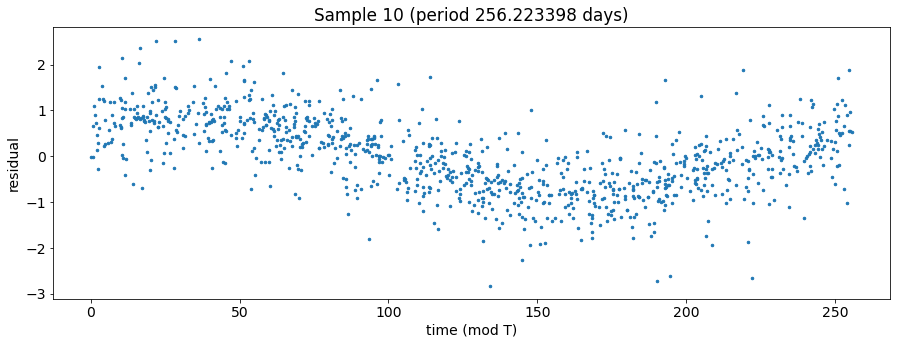

In [16]:
plt.figure(figsize=(15, 5))
res = (data[ind]- theta.dot(a_mat))#/err

plt.plot(t_ar%period_2, res, '.', markersize = 5)
#plt.plot(t_ar%236.05, res, '.', markersize = 5)

#plt.axhline(2, color = 'tab:red', linestyle = '--')
#plt.axhline(-2, color = 'tab:red', linestyle = '--')

plt.xlabel('time (mod T)')
plt.ylabel('residual')
plt.title(f'Sample {ind} (period {period_2} days)')

Text(0.5, 1.0, 'Sample 10')

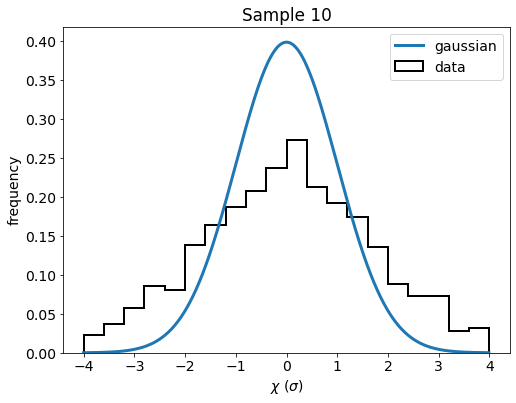

In [17]:
s_ar = np.arange(-4, 4, .01)
gauss = 1/np.sqrt(2*np.pi)*np.exp(-s_ar**2/2)

plt.figure(figsize = (8, 6))

plt.plot(s_ar, gauss, lw= 3, label = 'gaussian');
plt.hist(res/err, density = True, range = (-4, 4), bins = 20, 
         histtype = 'step', lw = 2, color = 'k', label = 'data');
plt.xlabel('$\chi$ ($\sigma$)')
plt.ylabel('frequency')
plt.legend()
plt.title(f'Sample {ind}')

It is clear that there is a second period present in this sample from the folded residual and also the non-gaussian distributed $\chi$.

## Q3.) 8-fold cross validation, AIC, BIC

In [18]:
ind_rand = np.arange(n_obs)
np.random.shuffle(ind_rand)

In [19]:
omega = 2*np.pi/100

chi_8_null = np.zeros(11)
chi_8_1p = np.zeros(11)

for i in range(8):
    ind_8 = np.delete(ind_rand, range(i*n_obs//8, (i+1)*n_obs//8))
    ind_pred = ind_rand[range(i*n_obs//8, (i+1)*n_obs//8)]
    
    t_8 = t_ar[ind_8]
    err_8 = err[ind_8]
    data_8 = data[:,ind_8]
    
    a_mat_8 = np.array([np.cos(omega*t_8), 
                        np.sin(omega*t_8), 
                        np.ones(7*n_obs//8)])

    cov_inv_8 = (a_mat_8/err_8**2).dot(a_mat_8.T)
    cov_inv_null_8 = np.sum(1/err_8**2)

    cov_8 = np.linalg.inv(cov_inv_8)
    cov_null_8 = 1/cov_inv_null_8
    
    suff_stat_8 = (a_mat_8/err_8**2).dot(data_8.T).T
    suff_stat_null_8 = (1/err_8**2).dot(data_8.T)
    
    theta_8 = cov_8.dot(suff_stat_8.T).T
    dc_8 = cov_null_8*suff_stat_null_8
    
    t_pred = t_ar[ind_pred]
    err_pred = err[ind_pred]
    data_pred = data[:, ind_pred]
    
    a_mat_pred = np.array([np.cos(omega*t_pred), 
                           np.sin(omega*t_pred), 
                           np.ones(n_obs//8)])
    
    chi_2 = np.sum(((data_pred - theta_8.dot(a_mat_pred))/err_pred)**2, axis = 1)
    chi_8_1p = chi_8_1p + chi_2
    
    chi_2_null = np.sum(((data_pred - np.expand_dims(dc_8, axis = 1))/err_pred)**2, axis = 1)
    chi_8_null = chi_8_null + chi_2_null
    

In [20]:
def chi2_2_freq_sum(theta, t_ar, data, err, omega2, omega = 2*np.pi/100, n_obs = n_obs):
    a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), 
                      np.cos(omega2*t_ar), np.sin(omega2*t_ar), 
                      np.ones(n_obs)])
    return np.sum(((theta.dot(a_mat) - data)/err)**2, axis = 1)

def chi2_2_freq_op(theta, t_ar, data, err, n_obs = n_obs, omega = 2*np.pi/100):
    omega2 = 2*np.pi/theta[-1]
    theta = theta[:-1]
    a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), 
                      np.cos(omega2*t_ar), np.sin(omega2*t_ar), 
                      np.ones(n_obs)])
    return np.sum(((theta.dot(a_mat) - data)/err)**2)

In [21]:
t_tot = t_ar[-1] - t_ar[0]

f_min = .5/t_tot/2*np.pi
f_max = n_obs/t_tot

f_ar = np.arange(f_min, f_max, f_min)
chi2_f = np.zeros((11, len(f_ar)))

chi_8_2p = np.zeros(11)

for i in tqdm(range(8)):
    chi2_f = np.zeros((11, len(f_ar)))
    
    ind_8 = np.delete(ind_rand, range(i*n_obs//8, (i+1)*n_obs//8))
    ind_pred = ind_rand[range(i*n_obs//8, (i+1)*n_obs//8)]
    
    t_8 = t_ar[ind_8]
    err_8 = err[ind_8]
    data_8 = data[:,ind_8]
    for j in range(len(f_ar)):
        omega2 = 2*np.pi*f_ar[j]
        a_mat_2_8 = np.array([np.cos(omega*t_8), np.sin(omega*t_8), 
                              np.cos(omega2*t_8), np.sin(omega2*t_8), 
                              np.ones(7*n_obs//8)])

        cov_inv_2_8 = (a_mat_2_8/err_8**2).dot(a_mat_2_8.T)
        cov_2_8 = np.linalg.inv(cov_inv_2_8)

        suff_stat_2_8 = (a_mat_2_8/err_8**2).dot(data_8.T).T
        theta_2_8 = cov_2_8.dot(suff_stat_2_8.T).T

        chi2_f[:,j] = chi2_2_freq_sum(theta_2_8, t_8, data_8, err_8, omega2, n_obs = 7*n_obs//8)
        
    f_max = f_ar[np.argmin(chi2_f, axis = 1)]
    #sol = []
    
    t_pred = t_ar[ind_pred]
    err_pred = err[ind_pred]
    data_pred = data[:, ind_pred]

    for j in range(11):
        p0 = np.concatenate([theta_2_8[j], [1/f_max[j]]])
        sol = op.minimize(chi2_2_freq_op, p0, 
                          args = (t_8, data_8[j], err_8, 7*n_obs//8), 
                          method = 'Nelder-Mead')
        
        theta_8 = sol.x[:-1]
        omega2 = 2*np.pi/sol.x[-1]
        
        a_mat_2_pred = np.array([np.cos(omega*t_pred), np.sin(omega*t_pred), 
                                 np.cos(omega2*t_pred), np.sin(omega2*t_pred), 
                                 np.ones(n_obs//8)])
        
        chi_2 = np.sum(((data_pred[j] - theta_8.dot(a_mat_2_pred))/err_pred)**2)
        
        chi_8_2p[j] = chi_8_2p[j] + chi_2
        

100%|██████████| 8/8 [00:08<00:00,  1.09s/it]


In [23]:
df = pd.DataFrame()
df['chi2_null'] = chi_8_null
df['chi2_1p'] = chi_8_1p
df['chi2_2p'] = chi_8_2p

best = []
for i in range(11):
    choice = np.argmin(df.loc[i])
    if choice == 0:
        best.append('null')
    elif choice == 1:
        best.append('1 period')
    else:
        best.append('2 period')
        
df['8-fold best'] = best
df

,chi2_null,chi2_1p,chi2_2p,8-fold best
0,1009.022342,1011.533139,1015.190228,null
1,1027.777589,1018.351508,1022.864733,1 period
2,1074.982920,999.389174,1008.301362,1 period
3,1544.910567,1046.634271,1056.077902,1 period
4,5960.370613,976.725423,981.924278,1 period
5,50595.213929,990.347460,999.662643,1 period
6,4367.133428,4386.476685,1019.131107,2 period
7,1356.340184,1295.970674,1081.146263,2 period
8,5048.252038,4430.240101,1021.708514,2 period
9,5944.716562,1125.033640,1149.764658,1 period


This table shows the $\chi^2$ for 8-fold cross-validation and the prefered model. This reproduced the conclusion I had back in Problem Set 2.

In [24]:
omega = 2*np.pi/100

a_mat = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), np.ones(n_obs)])

cov_inv = (a_mat/err**2).dot(a_mat.T)
cov_inv_null = np.sum(1/err**2)

cov = np.linalg.inv(cov_inv)
cov_null = 1/cov_inv_null

suff_stat = (a_mat/err**2).dot(data.T).T
suff_stat_null = (1/err**2).dot(data.T)

theta = cov.dot(suff_stat.T).T

dc = cov_null*suff_stat_null

In [25]:
chi2_1p = np.sum(((data - theta.dot(a_mat))/err)**2, axis = 1)
aic_1p = 2*3 + chi2_1p
bic_1p = 3*np.log(n_obs) + chi2_1p

chi2_null = np.sum(((data - np.expand_dims(dc, axis = 1))/err)**2, axis = 1)
aic_null = 2*1 + chi2_null
bic_null = 1*np.log(n_obs) + chi2_null

In [26]:
chi2_f = np.zeros((11, len(f_ar)))

for j in range(len(f_ar)):
    omega2 = 2*np.pi*f_ar[j]
    a_mat_2 = np.array([np.cos(omega*t_ar), np.sin(omega*t_ar), 
                        np.cos(omega2*t_ar), np.sin(omega2*t_ar), 
                        np.ones(n_obs)])

    cov_inv_2 = (a_mat_2/err**2).dot(a_mat_2.T)
    cov_2 = np.linalg.inv(cov_inv_2)

    suff_stat_2 = (a_mat_2/err**2).dot(data.T).T
    theta_2 = cov_2.dot(suff_stat_2.T).T

    chi2_f[:,j] = chi2_2_freq_sum(theta_2, t_ar, data, err, omega2)

f_max = f_ar[np.argmin(chi2_f, axis = 1)]


chi2_2p = np.zeros(11)
for j in range(11):
    p0 = np.concatenate([theta_2[j], [1/f_max[j]]])
    sol = op.minimize(chi2_2_freq_op, p0, 
                      args = (t_ar, data[j], err), 
                      method = 'Nelder-Mead')

    chi2_2p[j] = sol.fun

In [27]:
aic_2p = 2*6 + chi2_2p
bic_2p = 6*np.log(n_obs) + chi2_2p

In [28]:
df_aic = pd.DataFrame()
df_aic['aic_null'] = aic_null
df_aic['aic_1p'] = aic_1p
df_aic['aic_2p'] = aic_2p

best = []
for i in range(11):
    choice = np.argmin(df_aic.loc[i])
    if choice == 0:
        best.append('null')
    elif choice == 1:
        best.append('1 period')
    else:
        best.append('2 period')
        
df_aic['AIC best'] = best
df_aic

,aic_null,aic_1p,aic_2p,AIC best
0,1009.839164,1013.447060,1014.770324,null
1,1028.532614,1019.524516,1013.153334,2 period
2,1076.049925,1001.236930,995.832413,2 period
3,1541.383441,1045.915318,1046.978504,1 period
4,5884.766252,976.431487,969.548917,2 period
5,49561.490117,993.899116,997.326449,1 period
6,4343.262751,4332.697352,1021.303639,2 period
7,1351.877994,1290.717358,1081.096198,2 period
8,5001.043446,4380.176414,1024.288891,2 period
9,5893.882290,1124.526906,1123.270609,2 period


This table shows the prefered model using AIC.

In [29]:
df_bic = pd.DataFrame()
df_bic['bic_null'] = bic_null
df_bic['bic_1p'] = bic_1p
df_bic['bic_2p'] = bic_2p

best = []
for i in range(11):
    choice = np.argmin(df_bic.loc[i])
    if choice == 0:
        best.append('null')
    elif choice == 1:
        best.append('1 period')
    else:
        best.append('2 period')
        
df_bic['BIC best'] = best
df_bic

,bic_null,bic_1p,bic_2p,BIC best
0,1014.770636,1028.241475,1044.359155,null
1,1033.464086,1034.318931,1042.742164,null
2,1080.981397,1016.031346,1025.421244,1 period
3,1546.314913,1060.709733,1076.567334,1 period
4,5889.697724,991.225902,999.137748,1 period
5,49566.421589,1008.693532,1026.915280,1 period
6,4348.194223,4347.491767,1050.892470,2 period
7,1356.809466,1305.511773,1110.685029,2 period
8,5005.974917,4394.970829,1053.877722,2 period
9,5898.813761,1139.321322,1152.859440,1 period


This table shows the prefered model using BIC.